# Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 


2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 


3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 


6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 


Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### Предварительное исследование данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
import warnings
warnings.filterwarnings("ignore")

In [2]:
# olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
path_to_file = r'e:\000_Jupyter_notebooks\01. karpov.courses\06. Промежуточный проект\olist_customers_dataset.csv'
customers = pd.read_csv(path_to_file)

# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

In [3]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
customers.shape

(99441, 5)

In [5]:
# Посмотрим на типы данных в датафрейме
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
# Посмотрим есть ли пропущенные значения в данных
miss_customers = customers.isna().sum()
miss_customers[miss_customers > 0]

Series([], dtype: int64)

In [7]:
# Посмотрим есть ли дубликаты строк в датафрейме
customers.duplicated().sum()

0

In [8]:
# Посмотрим на описательную статистику по строковым столбцам
customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']].describe().T

,count,unique,top,freq
customer_id,99441,99441,06b8999e2fba1a1fbc88172c00ba8bc7,1
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17
customer_city,99441,4119,sao paulo,15540
customer_state,99441,27,SP,41746


* Количество уникальных пользователей - 96 096;
* Количество городов доставки - 4 119;
* Количество штатов доставки - 27.

In [9]:
# olist_orders_dataset.csv —  таблица заказов
path_to_file = r'e:\000_Jupyter_notebooks\01. karpov.courses\06. Промежуточный проект\olist_orders_dataset.csv'
orders = pd.read_csv(path_to_file, parse_dates=['order_purchase_timestamp',
                                                'order_approved_at',
                                                'order_delivered_carrier_date',
                                                'order_delivered_customer_date',
                                                'order_estimated_delivery_date'])

# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

# Уникальные статусы заказов в таблице olist_orders_dataset:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [10]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [11]:
# Посмотрим на типы данных в датафрейме
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [12]:
# Посмотрим есть ли пропущенные значения в данных
miss_orders = orders.isna().sum()
miss_orders[miss_orders > 0]

order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

Имеются пропущенные значения.
**160 заказов сформировано, но не оплачено.**

In [13]:
# Посмотрим есть ли дубликаты строк в датафрейме
orders.duplicated().sum()

0

In [14]:
# Посмотрим на описательную статистику по строковым столбцам
orders[['order_id', 'customer_id', 'order_status']].describe().T

,count,unique,top,freq
order_id,99441,99441,e481f51cbdc54678b7cc49136f2d6af7,1
customer_id,99441,99441,9ef432eb6251297304e76186b10a928d,1
order_status,99441,8,delivered,96478


Расммотрим подробнее заказы без оплаты.

In [15]:
# Посмотрим статусы по строкам с пустыми значениями по столбцу "order_approved_at" (время подтверждения оплаты заказа)
orders.query("order_approved_at == 'NaT'").order_status.value_counts().to_frame()

,order_status
canceled,141
delivered,14
created,5


Видим, что:
 *  у нас 141 отменённый заказ, соответственно не оплаченный;
 *  14 доставленных заказов, но с отсутствующими данными по оплате. Вероятнее всего это ошибка либо условия оплаты постоплата. Нужно разбираться детальнее.
 *  5 заказов сформировано, вероятно клиент ещё не закончил формирование заказа или же не успел оплатить.

Как мы видим, наличие не оплаченных заказов в большинстве случаев объяснется их отменой или же, статусом "Создан", когда клиент находится ещё в процессе формирования заказа. **Однако у нас есть данные со статусом доставлен, у которых информация об оплате отсутствует.**

In [16]:
# Посмотрим на распределение заказов по статусам
orders.order_status.value_counts().to_frame().T

,delivered,shipped,canceled,unavailable,invoiced,processing,created,approved
order_status,96478,1107,625,609,314,301,5,2


**609 заказов имеют статус unavailable/недоступен.** Проверим их на наличие оплаты.

In [17]:
unv_orders = orders.query("order_approved_at != 'NaT' and order_status =='unavailable'")
unv_orders.shape

(609, 8)

In [18]:
unv_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05


По всем 609 заказам имеется оплата. Возможно, предзаказы или ошибки с наличием товара на складе. Нужно разбираться детальнее.

Посмотрим теперь на статусы с пустыми значениями по полю order_delivered_carrier_date (время передачи заказа в логистическую службу).

In [19]:
# Посмотрим статусы по строкам с пустыми значениями по столбцу "order_delivered_carrier_date"
orders[orders.order_delivered_carrier_date.isnull()].order_status.value_counts().to_frame().T

,unavailable,canceled,invoiced,processing,created,approved,delivered
order_status,609,550,314,301,5,2,2


Очевидно, что отсутствующие значения вполне объяснимы тем что заказы находятся на разных стадиях и следовательно еще не переданы в логистистическую службу для доставки. **При этом у нас есть 2 строки со статусом доставлен.**

Посмотрим теперь на статусы с пустыми значениями по полю order_delivered_customer_date (время доставки заказа).

In [20]:
# Отобразим статусы по строкам с пустыми значениями по столбцу "order_delivered_customer_date"
orders[orders.order_delivered_customer_date.isnull()].order_status.value_counts().to_frame().T

,shipped,canceled,unavailable,invoiced,processing,delivered,created,approved
order_status,1107,619,609,314,301,8,5,2


Здесь также отсутствующие значения вполне объяснимы тем, что заказы находятся на разных стадиях и следовательно еще не доставлены клиенту. **Имеются также заказы отмеченные delivered, при этом дата доставки отсутствует.**

**Таким образом, можно сделать вывод, что в строках со статусом delivered и у которых при этом отсутствует информация о дате платежа, дате передачи в логистическую службу и дате доставки имеется какая-то ошибка (возможно, по каким-то причинам, даты не сохранились, а доставка осуществлена или неверно выставлен статус заказа).**

In [21]:
# olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
path_to_file = r'e:\000_Jupyter_notebooks\01. karpov.courses\06. Промежуточный проект\olist_order_items_dataset.csv'
items = pd.read_csv(path_to_file, parse_dates=['shipping_limit_date'])

# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

In [22]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [23]:
items.shape

(112650, 7)

In [24]:
# Посмотрим на типы данных в датафрейме
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [25]:
# Посмотрим есть ли пропущенные значения в данных
miss_items = items.isna().sum()
miss_items[miss_items > 0]

Series([], dtype: int64)

In [26]:
# Посмотрим есть ли дубликаты строк в датафрейме
items.duplicated().sum()

0

In [27]:
# Посмотрим на описательную статистику
items[['price', 'freight_value']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.90,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.15,409.68


-------------------------------------------------------------------------------------------------------------------------------

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Поскольку неизвестна специфика e-commerce, будем считать покупкой заказ при наличии следующих факторов:

***1-ое предположение:*** Произведена оплата за заказ.
* Подтвержена оплата заказа (order_approved_at != 'NaT')
* Статус заказа отличный от  unavailable/недоступен и canceled/отменён (order_status != 'unavailable' и order_status != 'canceled' )

***2-ое предположение:***
Теоретически возможно, что клиент может отказаться от заказа на любом этапе (после помещения заказа в корзину). Поэтому будем считать только доставленные клиенту заказы.
* 1 предположение + order_status == 'delivered'

In [28]:
# Мерджим customers и orders.
purchases = pd.merge(customers, orders, on='customer_id')
purchases.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [29]:
purchases.shape

(99441, 12)

In [30]:
# Проверим не изменилось ли количество пропущенных значений относительно исходных данных
miss_purchases = purchases.isna().sum()
miss_purchases[miss_purchases > 0]

order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

In [31]:
# Отберём данные, подходящие под критерии нашего 1-ого предположения.
one_purchase_v1 = purchases \
                  .query("order_approved_at != 'NaT' and \
                   order_status != ['unavailable', 'canceled']") \
                  .groupby('customer_unique_id') \
                  .agg({'order_id': 'nunique'}) \
                  .query("order_id == 1")
one_purchase_v1.shape

(92087, 1)

In [32]:
# Отберём данные, подходящие под критерии нашего 2-ого предположения.
one_purchase_v2 = purchases \
                  .query("order_approved_at != 'NaT' and \
                   order_status != ['unavailable', 'canceled'] and order_status == 'delivered'") \
                  .groupby('customer_unique_id') \
                  .agg({'order_id': 'nunique'}) \
                  .query("order_id == 1")
one_purchase_v2.shape

(90545, 1)

###  Ответ: 

Таким образом, количество пользователей, которые совершили покупку только один раз, исходя из вышеприведённых предположений того, что является покупкой, составляет  ***90 545 или 92 087 человек***.

-------------------------------------------------------------------------------------------------------------------------------

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

Учитывая информацию, полученную на этапе EDA, об имеющихся заказах с нарушенной логикой, будем считать, что 'недоставленный заказ' имеет статус:
- order_status == 'unavailable' и order_status == 'canceled';

In [33]:
#Для агрегации по времени воспользуемся методом resample. 
# Сначала переведем в индексы даты заказов.
df_res = purchases.set_index('order_purchase_timestamp').sort_values('order_purchase_timestamp')
df_res.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,,,,,
2016-09-04 21:15:19,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20
2016-09-05 00:15:34,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-10-07 13:17:15,NaT,NaT,2016-10-28
2016-09-13 15:24:19,622e13439d6b5a0b486c435618b2679e,009b0127b727ab0ba422f6d9604487c7,12244,sao jose dos campos,SP,809a282bbd5dbcabb6f2f724fca862ec,canceled,2016-10-07 13:16:46,NaT,NaT,2016-09-30


In [34]:
# Посмотрим на количество недоставленных заказов. 
df_res.query("order_status == ['unavailable', 'canceled']").order_id.nunique()

1234

In [35]:
df_res.query("order_status == ['unavailable', 'canceled']").resample('M').order_id.nunique().mean()

47.46153846153846

In [36]:
# В среднем в месяц не доставляется порядка 48-ми заказов.

In [37]:
unfulfilled_order = (df_res.query("order_status == ['unavailable', 'canceled']")
                     .groupby('order_status')
                     .resample('M')
                     .order_id.nunique()
                     .to_frame()
                     .reset_index()
                    )
unfulfilled_order.order_purchase_timestamp = unfulfilled_order.order_purchase_timestamp.dt.strftime('%Y-%m')
unfulfilled_order = unfulfilled_order.rename(columns={'order_purchase_timestamp': 'Month_and_year', 'order_id': 'Average_number_of_undelivered_orders' })
unfulfilled_order.head(3)

,order_status,Month_and_year,Average_number_of_undelivered_orders
0,canceled,2016-09,2
1,canceled,2016-10,24
2,canceled,2016-11,0


In [38]:
unfulfilled_order.groupby('order_status').agg({'Average_number_of_undelivered_orders':'mean'})

,Average_number_of_undelivered_orders
order_status,
canceled,24.038462
unavailable,26.478261


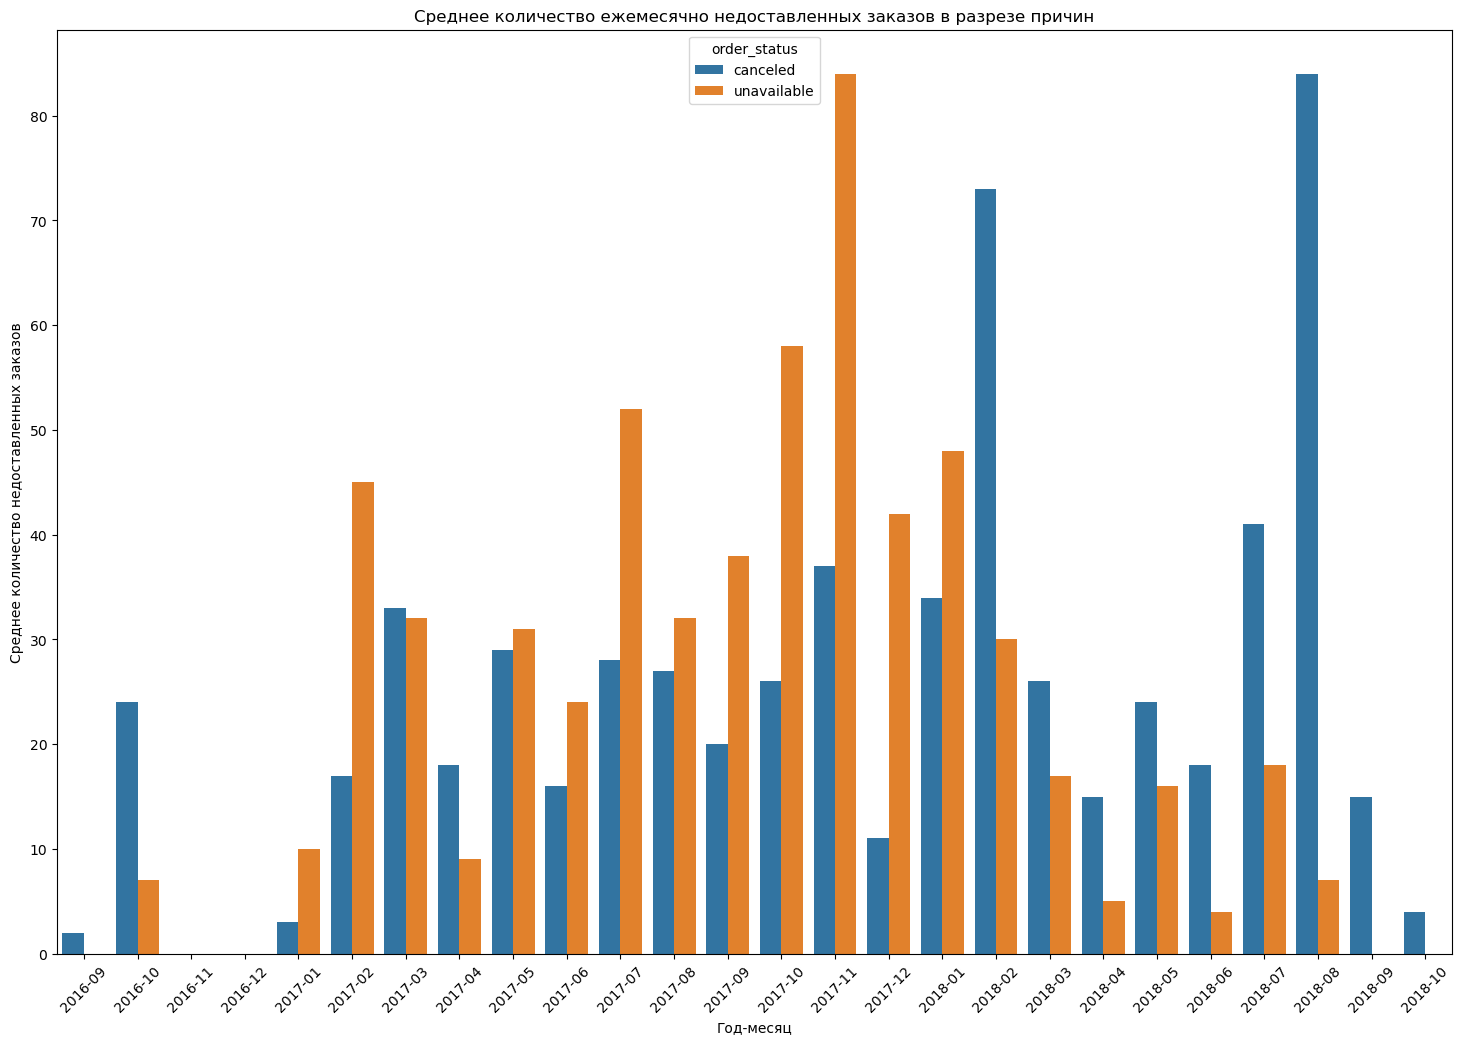

In [39]:
plt.figure(figsize=(18, 12))
ax = sns.barplot(x="Month_and_year", hue="order_status", y="Average_number_of_undelivered_orders", data=unfulfilled_order)
ax.set(title='Среднее количество ежемесячно недоставленных заказов в разрезе причин',
       xlabel='Год-месяц', 
       ylabel='Среднее количество недоставленных заказов')
plt.xticks(rotation=45)
plt.show()

### Ответ:

Общее количество недоставленных заказов: 1234.

**В среднем в месяц не доставляется порядка 48-ми заказов.**

Основные причины: 
* отмена / canceled = в среднем 24.038462 случая в месяц;
* недоступность заказа / unavailable  = в среднем 26.478261 случая в месяц.

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [40]:
# Считаем, что датой  покупки является order_approved_at —  время подтверждения оплаты заказа

In [41]:
# Объединим данные по заказам и товарам и отобразим первые 5 строк
goods = pd.merge(items, orders, on='order_id')
goods.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [42]:
goods['day_of_week'] = goods.order_approved_at.dt.day_name()
goods.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday


In [43]:
# Рассчитаем частоту покупок по дням для каждого товара и отобразим первые пять строк
purchase_frequency_df = goods.query('order_status == "delivered" & order_approved_at !="NaT"') \
        .groupby(['product_id', 'day_of_week'], as_index=False) \
        .agg(highest_frequency=('order_id', 'count')) \
        .sort_values('highest_frequency', ascending=False) \
        .groupby('product_id') \
        .head(1) \
        .reset_index() \
        .drop(columns='index')

purchase_frequency_df.head()

,product_id,day_of_week,highest_frequency
0,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
1,53b36df67ebb7c41585e8d54d6772e08,Tuesday,104
2,422879e10f46682990de24d770e7f83d,Tuesday,89
3,368c6c730842d78016ad823897a372db,Thursday,80
4,99a4788cb24856965c36a24e339b6058,Tuesday,78


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [44]:
# Добавляем следующие колонки:
purchases['order_year'] = purchases.order_purchase_timestamp.dt.year # колонка с годом 
purchases['order_month'] = purchases.order_purchase_timestamp.dt.month # с месяцем
purchases['weeks_in_month'] = round(purchases.order_purchase_timestamp.dt.days_in_month/7, 2) # с количеством недель

In [45]:
purchases.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,weeks_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,4.43
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,4.43
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,4.43


In [46]:
purchases_by_month = purchases.groupby(['customer_unique_id', 'order_year', 'order_month', 'weeks_in_month'], as_index=False) \
                              .agg({'order_id': 'nunique'}) \
                              .rename(columns={'order_id': 'number_of_purchases'})
purchases_by_month.head(5)

,customer_unique_id,order_year,order_month,weeks_in_month,number_of_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.43,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,4.43,1
2,0000f46a3911fa3c0805444483337064,2017,3,4.43,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,4.43,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,4.29,1


In [47]:
# Находим среднее количество покупок в неделю для каждого пользователя
purchases_by_month['avg_orders_week']= purchases_by_month['number_of_purchases']/purchases_by_month['weeks_in_month']
purchases_by_month.sort_values('avg_orders_week').head(5)

,customer_unique_id,order_year,order_month,weeks_in_month,number_of_purchases,avg_orders_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.43,1,0.225734
57225,95828271d6bee6d5eedcd00e639d67a6,2018,8,4.43,1,0.225734
57226,95834cf255d8c39ea415b7e35272ca13,2017,12,4.43,1,0.225734
57228,9585898e80f9de26178eb04cd600b6f5,2017,8,4.43,1,0.225734
57229,958843e128a10a8ae35155b6fc57fec3,2018,3,4.43,1,0.225734


In [48]:
# Среднее число покупок в неделю по всем пользователям.
round(purchases_by_month.avg_orders_week.mean(), 2)


0.23

### Ответ:  0.23 

Это означает, что наш среднестатистический пользователь  покупает не каждую неделю.

# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [49]:
# Определим дату, когда была совершена первая покупка каждым пользователем (b_day - день рождения)

first_purchase = purchases.groupby('customer_unique_id') \
                      .agg({'order_purchase_timestamp': 'min'}) \
                      .rename(columns={'order_purchase_timestamp': 'b_day'}) \
                      .b_day.dt.to_period('M')
first_purchase

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    2018-05
0000b849f77a49e4a4ce2b2a4ca5be3f    2018-05
0000f46a3911fa3c0805444483337064    2017-03
0000f6ccb0745a6a4b88665a16c9f078    2017-10
0004aac84e0df4da2b147fca70cf8255    2017-11
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    2017-06
fffea47cd6d3cc0a88bd621562a9d061    2017-12
ffff371b4d645b6ecea244b27531430a    2017-02
ffff5962728ec6157033ef9805bacc48    2018-05
ffffd2657e2aad2907e67c3e9daecbeb    2017-05
Name: b_day, Length: 96096, dtype: period[M]

In [50]:
# вставим серию в датафрейм purchases
purchases = pd.merge(purchases, first_purchase, on='customer_unique_id')
purchases.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,weeks_in_month,b_day
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,4.43,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,4.43,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,4.43,2018-05


In [51]:
# создадим колонку такого же формата с датами всех заказов
purchases['month_of_purchase'] = purchases.order_purchase_timestamp.dt.to_period('M')

In [52]:
purchases.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,weeks_in_month,b_day,month_of_purchase
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017,5,4.43,2017-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018,1,4.43,2018-01,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018,5,4.43,2018-05,2018-05


In [53]:
# для каждой покупки узнаем сколько времени прошло с первого заказа
purchases['month_diff'] = purchases['month_of_purchase'].subtract(purchases['b_day']) \
                                                       .apply(lambda x: x.n)

In [54]:
# развернем полученные данные 
cohort_table = purchases.pivot_table(
                                      columns='month_diff',
                                      index='b_day',
                                      values='customer_unique_id',
                                      aggfunc='nunique')
cohort_table

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [55]:
# найдем retention rate
retention_table = cohort_table.div(cohort_table[0], axis=0)
retention_table 

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


In [56]:
retention_2017 = retention_table.loc['2017-01': '2017-12']
retention_2017 

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005136,0.003595,0.002568,0.002825,0.002054,0.003082,0.001027,0.001798,0.002568,0.002311,0.003082,0.001284,0.002568,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006931,0.003346,0.002629,0.003585,0.005258,0.002868,0.002629,0.001434,0.001434,0.002390,0.001912,0.000956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006780,0.005327,0.002906,0.004600,0.002179,0.002179,0.002421,0.002906,0.001695,0.002663,0.000726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
ur_style = (retention_2017
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Greens',low=0.2, high=1, axis =0)
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,
2017-07,100.00%,0.51%,0.36%,0.26%,0.28%,0.21%,0.31%,0.10%,0.18%,0.26%,0.23%,0.31%,0.13%,0.26%,,,,,,
2017-08,100.00%,0.69%,0.33%,0.26%,0.36%,0.53%,0.29%,0.26%,0.14%,0.14%,0.24%,0.19%,0.10%,,,,,,,
2017-09,100.00%,0.68%,0.53%,0.29%,0.46%,0.22%,0.22%,0.24%,0.29%,0.17%,0.27%,0.07%,,,,,,,,


In [58]:
print(retention_2017.loc[:][3].idxmax())
print(retention_2017.loc[:][3].max())

2017-06
0.00414144632048423


### Ответ: Когорта с самым высоким retention на 3й месяц: "2017-06"

# 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации.

# Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

Выделим основные этапы для получения RFM оценки клиентов и рассчёта оценок R, F и M по шкале от 1 (худший) до 5 (лучший).

Основные этапы:
1. рассчитать новизну (recency) = количество дней с момента последней покупки
2. рассчитать частоту (frequency) = количество покупок за исследуемый период (обычно один год)
3. рассчитать стоимость/сумму трат клиента в денежном выражении (monetary) = общая сумма покупок, сделанных за исследуемый период
4. найти квинтили для каждого из этих измерений
5. расценить каждый параметр в зависимости от того, в каком квинтиле он находится
6. объединить баллы R, F и M, чтобы получить балл RFM
7. сопоставить оценки RF с сегментами


In [59]:
df = pd.merge(items, purchases, on='order_id')

In [60]:
df.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,customer_unique_id,customer_zip_code_prefix,...,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month,weeks_in_month,b_day,month_of_purchase,month_diff
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013,...,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017,9,4.29,2017-09,2017-09,0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775,...,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017,4,4.29,2017-04,2017-04,0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,35661,...,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018,1,4.43,2018-01,2018-01,0


In [61]:
# избавим наш dataset от NaN значений
df.dropna(inplace=True)

In [62]:
# Определяем момент времени для определения понятия "актуальность". 
# смоделируем наш сегодняшний день(под данным предполагаю плюс 1 день к максимальному дню доставки):
NOW = df['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-08-30 15:00:37')

In [63]:
# Далее группируем RFM таблицу, на основе которой мы и бдуем собирать RFM показатель 
# и  меняем названия столбцов для более удобства:

RFM_table = df.reset_index().groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (NOW - x.max()).days,
                                                                   'order_id': lambda x: len(x),
                                                                   'price': lambda x: x.sum()})

In [64]:
RFM_table.head(3)

,order_purchase_timestamp,order_id,price
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9
0000f46a3911fa3c0805444483337064,537,1,69.0


In [65]:
RFM_table.rename(columns={'order_purchase_timestamp': 'recency',
                         'order_id': 'frequency',
                         'price': 'monetary'}, inplace=True)

In [66]:
RFM_table.head(3)

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9
0000f46a3911fa3c0805444483337064,537,1,69.0


In [67]:
RFM_table.frequency.value_counts()
# Видим, что у нас очень много юзеров, которые покупали лишь 1 раз, поэтому для каждого параметра в RFM напишем по функции :)

1     81733
2      8796
3      1646
4       621
5       241
6       190
7        45
8        16
10       11
11       11
9        10
12        9
15        3
14        3
20        2
13        2
18        1
21        1
24        1
Name: frequency, dtype: int64

In [68]:
# Создадим функцию, которая  будет делить наших пользователей по разным показателям RFM:

In [69]:
quantiles = RFM_table.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_table

In [70]:
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x<=d[p][0.80]:
        return 2
    else:
        return 1

In [71]:
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x<=d[p][0.80]:
        return 4
    else:
        return 5

In [72]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=("frequency",quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215


In [73]:
segmented_rfm.RFMScore.nunique()

50

In [74]:
segmented_rfm.RFMScore.unique()

array(['414', '411', '112', '211', '215', '355', '114', '413', '111',
       '213', '412', '113', '311', '255', '512', '511', '555', '115',
       '254', '214', '313', '552', '513', '252', '554', '514', '315',
       '253', '212', '515', '455', '314', '415', '452', '153', '312',
       '454', '351', '155', '553', '353', '154', '152', '453', '451',
       '354', '251', '551', '151', '352'], dtype=object)

In [75]:
# Получили таблички с RFM_score
# Чем больший показатель получаем, тем лучше,
# например показатель 555 - тут платят недавно(R), часто(F), и много (M).
    # То есть такой пользователь самый лояльный и самый активный
# А если показатель 111 - платил очень давно(R), очень редко(F), и слишком мало(M)
    # Считай, что клиент потерян безвозвратно, и смысла его возвращать уже не будет.

In [76]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',         # Покупал очень давно, и заказов было мало. Считай, утерян!
    r'[1-2][3-4]': 'at risk',             # Покупал часто, но давно. Надо бы вернуть!
    r'[1-2]5': 'can\'t loose',            # Возвращался давно, хотя покупал часто. Надо бы вернуть!
    r'3[1-2]': 'about to sleep',          # Ниже среднего, нужно стимулировать, чтобы вернуть!
    r'33': 'need attention',              # Довольно средний пользователь, вроде не убегает.
    r'[3-4][4-5]': 'loyal customers',     # Покупает регулярно, на акции реагирует
    r'41': 'promising',                   # Покупал недавно, но много не тратит
    r'51': 'new customers',               # Был недавно, но покупает пока что не часто
    r'[4-5][2-3]': 'potential loyalists', # Клиент недавний, покупает довольно средне
    r'5[4-5]': 'champions'                # Тратит много, часто, регулярно!
}

segmented_rfm['Segment'] = segmented_rfm['r_quartile'].map(str) + segmented_rfm['f_quartile'].map(str)
segmented_rfm['Segment'] = segmented_rfm['Segment'].replace(segt_map, regex=True)
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,promising
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,promising
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,hibernating
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,hibernating


In [77]:
RFM_segments_size = segmented_rfm.groupby('Segment', as_index = False)\
                                 .agg({'RFMScore': 'count'}).sort_values('RFMScore', ascending=False)
RFM_segments_size['share'] = round(RFM_segments_size.RFMScore / sum(RFM_segments_size.RFMScore),2)

RFM_segments_size

,Segment,RFMScore,share
3,hibernating,32623,0.35
5,new customers,16427,0.18
0,about to sleep,16407,0.18
6,promising,16276,0.17
4,loyal customers,4732,0.05
1,can't loose,4582,0.05
2,champions,2295,0.02


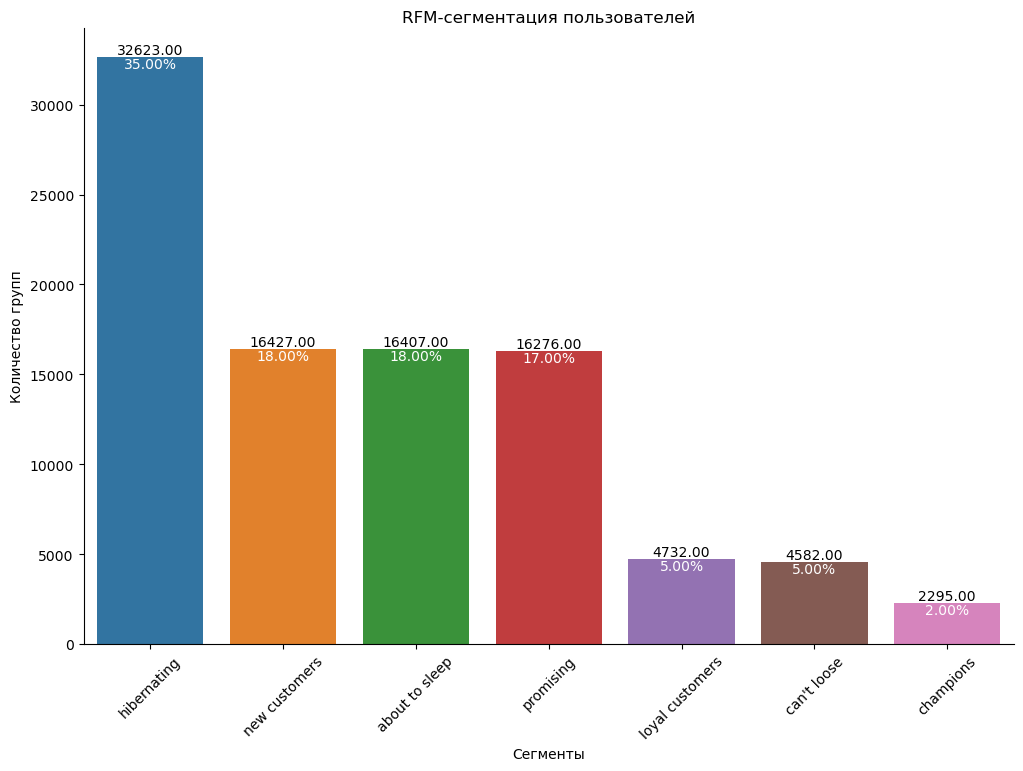

In [78]:
plt.figure(figsize=(12, 8))
barplot_RFM = sns.barplot(x='Segment', y='RFMScore', data=RFM_segments_size)
plt.title('RFM-сегментация пользователей', pad=5)
barplot_RFM.set(xlabel='Сегменты', ylabel='Количество групп')
for bar, share in zip(barplot_RFM.patches, RFM_segments_size['share']):
    height = bar.get_height()
    barplot_RFM.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
    barplot_RFM.text(bar.get_x() + bar.get_width() / 2, height - 0.05, f'{share:.2%}', ha='center', va='top', color='white')
plt.xticks(rotation=45)
sns.despine()
plt.show()

Как мы видим из данной диаграммы, больше трети (35%) наших  клиентов относятся к сигменту 'глубокоспящие' (hibernating), которые покупали редко и давно, могут уже и не вернутся. 
Основная аудитория это new customers, 'about to sleep', 'promising' (в совокупности 53%) совершает покупки не часто, можно было бы провести рекламную компанию, чтобы их активировать.
Лояльные покупатели ('champions' , 'loyal customers') в совокупности составляют 7%. Лояльность можно поддержать спец. условиями.
Особое внимание нужно уделить сигменту 'can't loose', пользователям, которые часто совершали покупки, а затем перестали.